<a href="https://colab.research.google.com/github/Ayush-mishra300840/Machine-translation-Hindi-to-English/blob/main/Bi_LSTM_Encoder_Decoder_Machine_Translation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# ***NOTE:***

In this phase, I have implemented Bi-LSTM for that I have refered to [***PyTorch Documentation***](https://pytorch.org/tutorials/intermediate/seq2seq_translation_tutorial.html) for implemntation level and [***Machine Translation and Sequence to Sequence Models CMU CS 11-731 FALL 2018***](http://www.phontron.com/class/mtandseq2seq2018/schedule.html#) currently I am learning too from this reference and for resolving errors and other stuff I have used ***StackoverFlow***

# ***Checking GPU***

In [ ]:
!nvidia-smi

Tue May  4 17:07:28 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 465.19.01    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   40C    P8     9W /  70W |      0MiB / 15109MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

#***Importing Different Libraries***


In [ ]:
import torch
import torch.nn as nn
from torch import optim
import torch.nn.functional as F
import numpy as np
import string
from string import digits
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split

from numpy import array, argmax
from numpy.random import rand, shuffle
import scipy
import sklearn
from io import open
import unicodedata
import random
import math
import time
import os
import csv
import nltk

import time
import re
import sys
from unicodedata import normalize
from numpy import array
from pickle import dump, load

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


#***Importing NLTK***


In [ ]:
nltk.download('punkt', quiet=True)

True

#***Importing INDICNLP***


In [ ]:
!git clone "https://github.com/anoopkunchukuttan/indic_nlp_library"
!git clone https://github.com/anoopkunchukuttan/indic_nlp_resources.git
!pip install Morfessor
#The path to the local git repo for Indic NLP library
INDIC_NLP_LIB_HOME=r"/content/indic_nlp_library"

# The path to the local git repo for Indic NLP Resources
INDIC_NLP_RESOURCES=r"/content/indic_nlp_resources"

Cloning into 'indic_nlp_library'...
remote: Enumerating objects: 1271, done.
remote: Counting objects: 100% (93/93), done.
remote: Compressing objects: 100% (68/68), done.
remote: Total 1271 (delta 50), reused 54 (delta 25), pack-reused 1178
Receiving objects: 100% (1271/1271), 9.56 MiB | 14.43 MiB/s, done.
Resolving deltas: 100% (654/654), done.
Cloning into 'indic_nlp_resources'...
remote: Enumerating objects: 133, done.
remote: Counting objects: 100% (7/7), done.
remote: Compressing objects: 100% (7/7), done.
remote: Total 133 (delta 0), reused 2 (delta 0), pack-reused 126
Receiving objects: 100% (133/133), 149.77 MiB | 39.21 MiB/s, done.
Resolving deltas: 100% (51/51), done.


In [ ]:
import sys
sys.path.append(r'{}'.format(INDIC_NLP_LIB_HOME))
from indicnlp import common
common.set_resources_path(INDIC_NLP_RESOURCES)
from indicnlp import loader
loader.load()

In [ ]:

from indicnlp.normalize.indic_normalize import IndicNormalizerFactory
from indicnlp.tokenize import indic_tokenize
from indicnlp.normalize.indic_normalize import BaseNormalizer


#***Mounting Google Drive***


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


#***Initialinzing Dictionaries***




Here I have used 3 dictionary amnd a varible to tell number of words for both hindi and english.\
word2index used for converting each distinct word to index for tensor.\
index2word used for converting each index to word i.e. we have output tensor and we want to convert it into sentence so I use this dictionary for that.\
word2count this dictionary is used for analysis work only i want to know frequency of each word. So, maybe in future this will help me while attention model or decoding.\
hi/en_n_words is varible which is used for count number of word.\
SOS, EOS, PAD are three tokens used for start of sentence, end of sentence, padding. As full form tell about usage of SOS and EOS, So i directly tell why I used PAD sequence here for two usage first in case if model found any word which doesn't have any index in word2index, So I used PAD token and other for future work I am learning how to use  packed padding sequence and masking. Packed padded sequences are used to tell our model to skip over padding tokens in our encoder and masking explicitly forces the model to ignore certain values, such as attention over padded elements. Both of these techniques are commonly used in NLP.

In [ ]:
hi_word2index = {"SOS": 0, "EOS": 1, "PAD": 2}
hi_word2count = {}
hi_index2word = {0: "SOS", 1: "EOS", 2:"PAD"}
hi_n_words = 3 


In [ ]:
en_word2index = {"SOS": 0, "EOS": 1, "PAD": 2}
en_word2count = {}
en_index2word = {0: "SOS", 1: "EOS", 2:"PAD"}
en_n_words = 3 

In [ ]:
dataset = []
with open('./drive/MyDrive/MT_HtoE/train.csv', 'r') as file:
  dataset = np.array([[row[1], row[2]] for row in csv.reader(file)])[1::]

In [ ]:
def pre_process_hindi_sentence(line):
    line=re.sub('[a-zA-Z]', '', line)
    line = clean_text(line)
    remove_nuktas = False
    normalizer = BaseNormalizer("hi", remove_nuktas=False)
    line = normalizer.normalize(line)
    tokens = list()
    for t in indic_tokenize.trivial_tokenize(line):
        tokens.append(t)
    line = tokens
    line = [word for word in line if not re.search(r'\d', word)]
    line = ' '.join(line)
    return (line)

In [ ]:
def clean_text(text):
    li=["'",",","(",")",":","@","\\","?","_","'",'"',"|",".",'``','"',"-","’’","‘‘",'"',"''","’’","‘‘",]
    for i in range(len(li)):
      text= text.replace(li[i],'')
    text=re.sub('[0-9+\-*/.%]', '', text)
    text=text.strip()
    text=re.sub(' +', ' ',text)
    exclude = set(string.punctuation)
    text= ''.join(ch for ch in text if ch not in exclude)
    return text

In [ ]:
def pre_process_english_sentence(line):
    line = line.lower()
    line = clean_text(line)
    re_print = re.compile('[^%s]' % re.escape(string.printable))
    line = normalize('NFD', line).encode('ascii', 'ignore')
    line = line.decode('UTF-8')
    line = line.split()
    line = [re_print.sub('', w) for w in line]
    line = [word for word in line if word.isalpha()]
    line = ' '.join(line)
    return line

#***Making Vocabulary of Hindi Training DataSet***

hi_vocab is list hindi sentences after tokenization and used INDIC NLP for tokenization and update dictionaries and word count

In [ ]:
hin_vocab = []

for row in dataset:
    
    # Hindi Sentences:
    temp = indic_tokenize.trivial_tokenize(row[0])
    hin_vocab += [temp]
    
    for word in temp:
        if word not in hi_word2index.keys():
            hi_word2index.update({word: hi_n_words})
            hi_index2word.update({hi_n_words: word})
            hi_n_words += 1


#***Making Vocabulary of English Training DataSet***


en_vocab is list english sentences after tokenization. I have used NLTK word tokenization because of some error in spacy and update dictionaries and word count

In [ ]:
en_vocab = []
for row in dataset:
  # English Sentences:
    temp = nltk.word_tokenize(row[1])
    en_vocab += [temp]

    for word in temp:
        if word not in en_word2index.keys():
            en_word2index.update({word: en_n_words})
            en_index2word.update({en_n_words: word})
            en_n_words += 1

hi_max and en_max is variables used for storing maximum length from courpus.

In [ ]:
hi_max = max([len(l) for l in hin_vocab])
en_max = max([len(l) for l in en_vocab])

In [ ]:
print(en_n_words,hi_n_words,len(hi_index2word.keys()),len(en_index2word.keys()),hi_max,en_max)

40801 46383 46383 40801 596 446


In [ ]:
print('Hi-Vocabulary Size:', len(hi_index2word))
print('En-Vocabulary Size:', len(en_index2word))
MAX_LENGTH=100

Hi-Vocabulary Size: 46383
En-Vocabulary Size: 40801


#***Making Tensor Of Hindi Training DataSet***


hi_train and en_train are lists of tensors for that I have used [***torch.tensor***](https://pytorch.org/docs/stable/tensors.html)\
Here I used all training dataset and convert them into tensors with the help of word2index dictionary and also appended start of sentence and end of sentence

In [ ]:
hi_train = []

for seq in hin_vocab:
    word_list = []
    for word in seq:
        if word in hi_word2index.keys():
            word_list += [hi_word2index[word]]
        else:
            word_list += [hi_word2index["PAD"]]

    seq = torch.tensor([hi_word2index["SOS"]] + word_list + [hi_word2index["EOS"]]).to(device)
    #converting (m,n) array into (m*n,1) array
    hi_train += [seq.reshape(-1, 1)]


#***Making Tensor Of English Training DataSet***


In [ ]:
en_train = []

for seq in en_vocab:
    word_list = []
    for word in seq:
        if word in en_word2index.keys():
            word_list += [en_word2index[word]]
        else:
            word_list += [en_word2index["PAD"]]

    seq = torch.tensor([en_word2index["SOS"]] + word_list + [en_word2index["EOS"]]).to(device)
    #converting (m,n) array into (m*n,1) array
    en_train += [seq.reshape(-1, 1)]

In [ ]:
!nvidia-smi

Tue May  4 17:12:29 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 465.19.01    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   37C    P0    26W /  70W |   1154MiB / 15109MiB |      5%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

#***Encoder Model***





Naive implentation of RNN cuases vanishing gradient, So I have used [***Long-Short Term Memory***](https://en.wikipedia.org/wiki/Long_short-term_memory) as a recurrent model. So, for implementing LSTM I have used PyTorch library [***torch.nn.LSTM***](https://pytorch.org/docs/stable/generated/torch.nn.LSTM.html). This module also allows us to use bi-directional sequential processing which allows to know and capture thr backward and forward relation both of a sentence

I have used embedding module to convert word indices into dense vector which allows to projecting different words into continuous space for checking the semantical relation in spatial words position. I have done this because I don't have pre-trained word embedding for that I used [***torch.nn.Embedding***](https://pytorch.org/docs/stable/generated/torch.nn.Embedding.html).\
Bi-directional processing will ouput vectors of double size, therefore I tried to reduced output dimensionality I got lot of error due to this problem

Dimensionalities:\
input_seq: (batch size, sequence length) i.e. something like an array of sequences of length seq_length, where array length is batch_size.\
embedded (batch size, sequence length, hidden size)\
hidden: (h or c, layers direction, batch, sequence length) here h is hidden state and c is memory in an LSTM cell [*ref*](https://www.quora.com/How-is-the-hidden-state-h-different-from-the-memory-c-in-an-LSTM-cell)
h: (num_layers\*directions, batch_size, hidden_size),
c: (num_layers\*directions, batch_size, hidden_size))

In [ ]:
class EncoderModel(torch.nn.Module):
    
    def __init__(self, input_size, hidden_size, num_layers=1):
      # avoid referring to the base class explicitly
        super(EncoderModel, self).__init__()
        self.hidden_size=hidden_size
        self.embedding = torch.nn.Embedding(input_size,hidden_size)
        self.rnn = torch.nn.LSTM(hidden_size,hidden_size,num_layers, bidirectional=True)

    def forward(self, input_seq, hidden):
        embedded = self.embedding(input_seq).view(1, 1, -1)
        # hidden output of LSTM
        # hidden cell h: (num_layers*directions, batch_size, hidden_size),
        # memory cell c: (num_layers*directions, batch_size, hidden_size))
        output, hidden = self.rnn(embedded, hidden)
        #adding forward layer and backward layer.
        output = torch.cat((output[:, :, :hidden_size], output[:, :,hidden_size:]))
        return output, hidden

    def init_hidden(self):
        # we have 2 cells hidden cell and memory cell
        
        return (torch.zeros( 1* 2, 1,hidden_size, device=torch.device('cuda')),
                torch.zeros( 1* 2, 1,hidden_size, device=torch.device('cuda')))

#***Attention Decoder Model***



I have used Luong Attention model.

Attention allows the decoder network to "focus" on a different part of the encoder output with each step of the decoder results itself. First I have counted the set of weights of attention. This will be repeated with the sump output vectors to create a weighted compound. Attention calculations are done with another layer of feed transfer, using decoder input and a hidden state such as input. Because there are sentences for all sizes in training data, in order to build and train this layer we must choose the length of the sentence (the length of the insert, the output of the insert) that can work. The longer sentences will use all the attention tools, while the short sentences will only use the first few.\
I have used batch matrix multiplication [***torch.bmm***](https://pytorch.org/docs/stable/generated/torch.bmm.html) for multiplying 3-D tensor and used ReLU [***torch.nn.ReLU***](https://pytorch.org/docs/stable/generated/torch.nn.ReLU.html) as activation fuction and used log_softmax for alignment score for each encoder hidden state.  

Attention Decoder RNN Model hidden weights are conditioned on encoding of source sequence from encoder. It generates probability distribution on the target vocabulary after applying attention on each time-step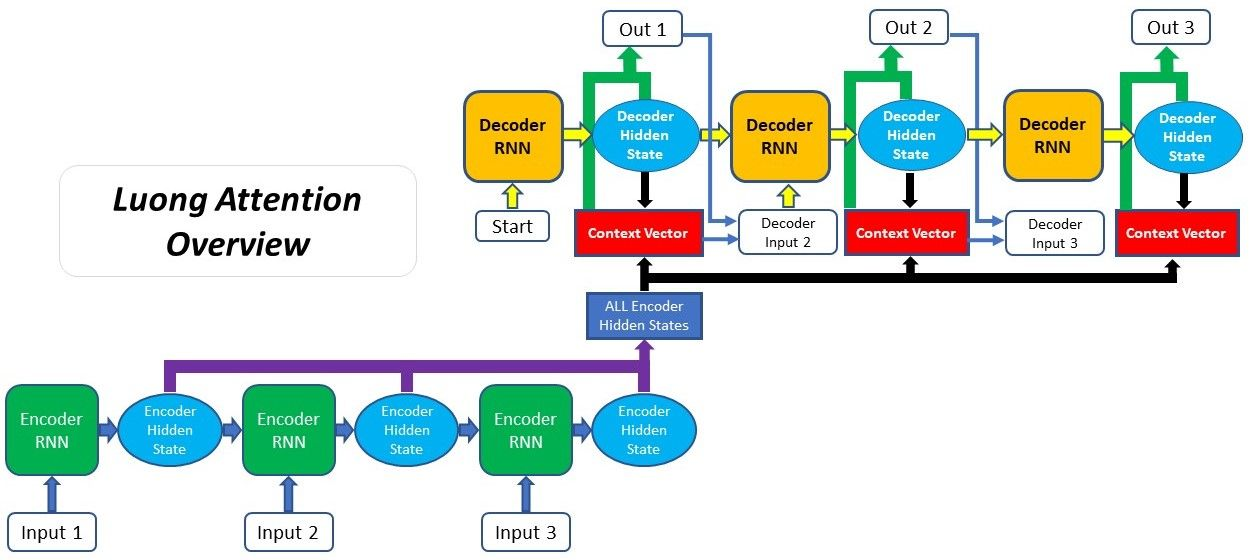
ref: https://blog.floydhub.com/attention-mechanism/

Steps in Attention model:

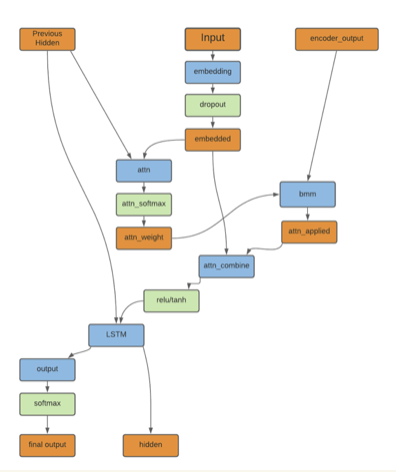

In [ ]:
class AttnDecoderModel(torch.nn.Module):
   def __init__(self, hidden_size, output_size, num_layers=1,dropout_prob=0.1, max_length=MAX_LENGTH):
        # avoid referring to the base class explicitly
        super(AttnDecoderModel, self).__init__()
        

        self.embedding = nn.Embedding(output_size, hidden_size)

        self.attn = nn.Linear(hidden_size * 2, max_length)
        self.attn_combine = nn.Linear(hidden_size * 2, hidden_size)

        self.dropout = nn.Dropout(dropout_prob)

        self.rnn = nn.LSTM(hidden_size, hidden_size,num_layers, bidirectional=True)
        self.out = nn.Linear(hidden_size, output_size)

   def forward(self, input_seq, hidden, encoder_outputs):
     #embedding input words
        embedded = self.dropout(self.embedding(input_seq).view(1, 1, -1))
      # to get the attention weight calculating softmax of alignment score
        attn_weights = torch.nn.functional.softmax(self.attn(torch.cat((embedded[0], hidden[0][0]), 1)), dim=1)
        #multiplying the attention weight with the encoder output to get the context vector
        attn_applied = torch.bmm(attn_weights.unsqueeze(0),encoder_outputs.unsqueeze(0))
        #concating context vector with input embedding so that we can get the output
        output = torch.cat((embedded[0], attn_applied[0]), 1)
        #to overecome the vanishing gradient problem, and allow my model to learn faster and better performance
        output = torch.nn.functional.relu(self.attn_combine(output).unsqueeze(0))

        output, hidden = self.rnn(output, hidden)
        #adding forward and backward layer
        output = torch.cat((output[:, :, :hidden_size], output[:, :, hidden_size:]))
        output = torch.nn.functional.log_softmax(self.out(output[0]), dim=1)
        return output, hidden, attn_weights

   def init_hidden(self):
     # we have 2 cells hidden cell and memory cell
        return (torch.zeros( 1* 2, 1,hidden_size, device=torch.device('cuda')),
                torch.zeros( 1* 2, 1,hidden_size, device=torch.device('cuda')))

#***Train The Model***


In PyTorch, we need to set the gradients to zero before backpropragation because PyTorch accumulates the gradients on subsequent backward passes. So, I have encoder_optimizer.zero_grad() and decoder_optimizer.zero_grad(). After that, I have used negative log-likelihood loss and also intialize tensor of input_length and output_length. here first I have initialize encoder_hidden and encoder_output as zeros. I have saved encoder_output of each input after that I have initialized decoder_input and decoder_hidden.\
Here, I have used teacher_forcing as 0.5

In [ ]:
teacher_forcing_ratio = 0.5

def train(input_tensor, target_tensor, encoder, decoder, encoder_optimizer, decoder_optimizer, criterion, max_length):
    #https://stackoverflow.com/questions/48001598/why-do-we-need-to-call-zero-grad-in-pytorch
    #set the gradients to zero before starting backpropragation because PyTorch accumulates the gradients on subsequent backward passes
    encoder_optimizer.zero_grad()
    decoder_optimizer.zero_grad()

    loss = 0
    target_lens = 0
    input_length = input_tensor.size(0)
    target_length = target_tensor.size(0)
    loss_function = nn.NLLLoss()
    #intializing encoder hidden and encoder output to zeros
    encoder_hidden = encoder.init_hidden()
    encoder_outputs = torch.zeros(max_length, encoder.hidden_size, device=torch.device('cuda'))
    #here for each input in tensor 
    for ei in range(input_length):
        encoder_output, encoder_hidden = encoder(input_tensor[ei], encoder_hidden)
        encoder_outputs[ei] = encoder_output[0]

#initializing decoder input and hidden state
    decoder_input = torch.tensor([[0]], device=torch.device('cuda'))
    decoder_hidden = encoder_hidden
    #random.random() provides values 0 to 1
    use_teacher_forcing = True if random.random() < teacher_forcing_ratio else False

    if use_teacher_forcing:
      #feed the target as the input to next
        for di in range(target_length):
          #output of decoder
            decoder_output, decoder_hidden, _ = decoder(decoder_input,decoder_hidden, encoder_outputs)
            
            # loss += criterion(decoder_output, target_tensor[di])
            loss += loss_function(decoder_output, target_tensor[di])
            
            decoder_input = target_tensor[di]
    else:
      #here predict by own without teacher forcing
        for di in range(target_length):
            decoder_output, decoder_hidden, _ = decoder( decoder_input, decoder_hidden, encoder_outputs)
            #take top output I have passed 1 for output. Returns the k largest elements of the given input tensor along a given dimension.
            _, topi = decoder_output.topk(1)
            #  Detaching a tensor removes it from the computational graph so no longer need of tracking gradient.
            # the previous token can be seen as a constant defining the starting point, it will be discarded after one time step
            decoder_input = topi.squeeze().detach()
            # loss += criterion(decoder_output, target_tensor[di])

            loss += loss_function(decoder_output, target_tensor[di])

            #check EOS.
            if decoder_input.item() == 1:
                break     
    #computes the derivative of the loss w.r.t. the parameters using backpropagation.
    loss.backward()
    
    #causes the optimizer to take a step based on the gradients of the parameters.
    encoder_optimizer.step()
    decoder_optimizer.step()

    return loss.item() / target_length

In this section I have train my model on number of epochs. but while trining my model I have used 1 epoch and save model because of limited time to use GPU in colab.
Here I have used negative log likelihood for loss criterion. I have shuffle training data using np.random.permutation and store indexes in a list. I have also tried to sort the training data according to lengths but takes time to sorting but loss not change a lot so atlast I used random training. Its depending on individual.
Here I have calculated average loss per 10K training data.
In training function, I have passed tensor of Hindi training data and English training data.and also passed encoder, decoder, Encoder_optimizer, Decoder_optimizer, loss funtion and maximum length of hindi sentences and english sentences

#***Capturing Loss And Time For Training Model And Initializing Loss***


In [ ]:
def trainEpochs(enc, dec, enc_opt, dec_opt, epochs, maxlen=100):
    
    start = time.time()
    length_vocab = len(hin_vocab)
    criterion = torch.nn.NLLLoss()

    for epoch in range(epochs):
        input_li = np.random.permutation(length_vocab)
        avg_loss = 0;
        per_epoch_loss =0;
        train_data = 0
        for iter in input_li:
            loss = train(hi_train[iter], en_train[iter] , enc, dec, enc_opt, dec_opt, criterion, maxlen)
            avg_loss += loss
            train_data += 1
            if train_data == 10000:
                end = time.time()
                print('*****')
                print(f'Epoch: {epoch + 1}, Done training {train_data}/{length_vocab}')
                print(f'Time : {end - start} Seconds')
                print(f'Average loss after 10k training data: {avg_loss/10000}')
                per_epoch_loss += (avg_loss/10000)
                start = time.time()
                train_data =0
                avg_loss =0
        print(f'Average loss after {epoch+1} training data: {per_epoch_loss}')

#***Initialize Encoder-Decoder Model***

In [ ]:
hidden_size = 512

enc = EncoderModel(hi_n_words, hidden_size).to(device=torch.device('cuda'))
dec = AttnDecoderModel(hidden_size, en_n_words, 1,0.1, max(hi_max, en_max) + 3).to(device=torch.device('cuda'))

enc_opt = torch.optim.SGD(enc.parameters(), lr=0.03)
dec_opt = torch.optim.SGD(dec.parameters(), lr=0.03)


#enc_opt = torch.optim.SGD(enc.parameters(), lr=0.001,momentum = 0.95)
#dec_opt = torch.optim.SGD(dec.parameters(), lr=0.001, momentum=0.95)



#***Code to Run Train Model***

In [ ]:
No_epochs = 1
trainEpochs(enc, dec, enc_opt, dec_opt, No_epochs, maxlen=max(hi_max, en_max) + 3)

#***Saving State_dict / Model***

In [ ]:
torch.save(enc.state_dict(), "drive/MyDrive/phase4/try1/newenc.pt")
torch.save(dec.state_dict(), "drive/MyDrive/phase4/try1/newdec.pt")
torch.save(enc_opt.state_dict(), "drive/MyDrive/phase4/try1/newenc_opt.pt")
torch.save(dec_opt.state_dict(), "drive/MyDrive/phase4/try1/newdec_opt.pt")

#***Loading State_Dict***

Here is the link of all epocs that i trained [link](https://drive.google.com/drive/folders/1A24QnKqJ6WvZpRCvJHs82W-QWX_gTLvR?usp=sharing)

In [ ]:
enc.load_state_dict(torch.load("drive/MyDrive/phase4/TEST_PHASE_MODEL/12enc.pt"))   
dec.load_state_dict(torch.load("drive/MyDrive/phase4/TEST_PHASE_MODEL/12dec.pt"))
enc_opt.load_state_dict(torch.load("drive/MyDrive/phase4/TEST_PHASE_MODEL/12enc_opt.pt"))
dec_opt.load_state_dict(torch.load("drive/MyDrive/phase4/TEST_PHASE_MODEL/12dec_opt.pt"))

#***Translating Hindi To English***

In [ ]:
def translate(encoder, decoder, sentence, max_length):

    with torch.no_grad():
        #tokenzize the sentence and then make tensor
        # here while Translation i have not normalize hindi sentence 
        seq = indic_tokenize.trivial_tokenize(sentence)
        temp = []
        for word in seq:
          if word in hi_word2index.keys():
            temp += [hi_word2index[word]]
          else:
            temp += [hi_word2index["PAD"]]
        # making tensor from sequence 
        seq = torch.tensor([hi_word2index["SOS"]] + temp + [hi_word2index["EOS"]]).to(device=torch.device('cuda'))

        input_tensor = seq.reshape(-1, 1).to(device=torch.device('cuda'))

        #intialization of encoder_hidden and encoder_outputs
        input_length = input_tensor.size()[0]
        
        encoder_hidden = encoder.init_hidden()
        #encoder_outputs zeros of lengths of sentence and hidden_size
        encoder_outputs = torch.zeros(max_length, encoder.hidden_size, device=torch.device('cuda'))
        # encoding each character 
        for ei in range(input_length):
            encoder_output, encoder_hidden = encoder(input_tensor[ei],encoder_hidden)
            encoder_outputs[ei] += encoder_output[0, 0]

        #intialize decoder_inputs and decoder hidden 
        decoder_input = torch.tensor([[0]], device=device) # init of sentence
        # decoder hidden must same size of encoder hidden
        decoder_hidden = encoder_hidden
        # list of decoded word that possibly we get 
        decoded_words = []
        # since we have output 3 parameter in decoder so I have also intialize decoder_attention.
        decoder_attentions = torch.zeros(max_length, max_length)
        # decoding word in range of number of words in input sentence
        for di in range(max_length):
            decoder_output, decoder_hidden, decoder_attention = decoder(decoder_input, decoder_hidden, encoder_outputs)
            #take top output I have passed 1 for output. Returns the k largest elements of the given input tensor along a given dimension.

            topv, topi = decoder_output.data.topk(1)
            #check EOS or not.
            if topi.item() == 1:
                decoded_words.append("EOS")
                break
            else:
                decoded_words.append(en_index2word[topi.item()])
            #  Detaching a tensor removes it from the computational graph so no longer need of tracking gradient.
            decoder_input = topi.squeeze().detach()

        return decoded_words

#***Importing Test Data And Generating Output***

In [ ]:
test_data = []
with open('./drive/MyDrive/MT_HtoE/testhindistatements.csv', 'r') as file:
  test_data = np.array([[row[2],''] for row in csv.reader(file)])[1::]

In [ ]:
print(test_data[0])

['(तालियां) अब, इसने मेरे मन को उड़ा दिया।' '']


In [ ]:
output_sents = []
with open('./drive/MyDrive/answer.txt', 'w') as f:
  i=0
  for line in test_data:
    if i==5:
      break
    t = translate(enc, dec, line[0], max(hi_max, en_max) + 3)
    # code  for 
    t="".join([" "+i if not i.startswith("'") and i not in string.punctuation else i for i in t]).strip()
    t=t.replace("SOS","")
    t=t.replace("EOS","")
    t=t.replace("PAD","")
    print(t)
    #f.write(t)
    #f.write("\n")
    i+=1
f.close()

( Applause),,,,,,... 
 But you're not.... 
 The is is is. the...... 
 Please listen to me. 
 No, you ca n't do you. 
